# <font color=blue><center>Fitting DEER data with Convolutional Networks</center></font>
***

## This notebook allows the user to explore the fitting of Deer decays with a convolutional network to obtain the underlying distance distribution. A writeup and Dashboard for this project can be found at __[GitHub](https://github.com/RS-ND/Capstone-Project.git)__
***
### In this notebook the user will create a distance distribution and the 2B model will then predict the distance distribution based on the simulated Deer decay.

#### Input Distance Distribution $\xrightarrow{\text{simulate}}$ Deer Data $\xrightarrow{\text{fit with model}}$ Output Distance Distribution $\xrightarrow{\text{calculate}}$ Output Deer Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import fresnel
from scipy.stats import norm
from torch import from_numpy
import model_load

In [2]:
# needed to make table at user interface show up to the left has to be in cell by itself
# (seestems answer @ https://stackoverflow.com/questions/45354207/align-jupyter-notebook-tables-to-the-left?rq=1)

In [3]:
%%html
<style>
    /* Jupyter */
    .rendered_html table,
    /* Jupyter Lab*/
    div[data-mime-type="text-markdown"] table {
        margin-left: 0
    }
</style>

#### Input the model
-  At present only the 2B model can be utilized.

In [4]:
model = model_load.load('./models','2B')

#### Create the basis set (Kernel) for calculating the Deer Decay

In [5]:
r = np.arange(10,100.1,0.1)
t = np.arange(-0.2,2.8,0.01)*1e-6
len_r = len(r)
len_t = len(t)
w = 326.977e+09/(r**3)
w_tile = np.tile(w, (len_t, 1)).T
t_tile = np.tile(np.abs(t), (len_r, 1))
a = 3 * w_tile * t_tile
q = np.sqrt(2*a/np.pi)
ss, cs = fresnel(q)
cs = cs/q
ss = ss/q
ineq0 = q == 0.0
cs[ineq0] = 0
ss[ineq0] = 0
basis = cs * np.cos(w_tile*t_tile) + ss * np.sin(w_tile*t_tile)
basis[ineq0] = 1
basis = basis.T

#### Functions to calculate the distance distribution, create the deer decay, fit the deer decay, and output the results

In [6]:
def g_dist_calc(params):
    '''Calculate a Gaussian distance distribution'''
    num_gauss = np.shape(params)[0]
    g_dist = np.zeros(np.shape(r))
    for i in range(0,num_gauss):
        temp_d = params[i][0] * norm.pdf(r, params[i][1], params[i][2])
        g_dist += temp_d
    g_dist = g_dist / np.sum(g_dist)
    return g_dist

def predict_deer(basis,g_dist,model):
    '''Calculate a predicted distribution from an input distribution'''
    deer_sim = np.matmul(basis,g_dist)
    indata = from_numpy(deer_sim).unsqueeze(0).float().unsqueeze(1)
    output = model(indata)
    dist_out = output.numpy().reshape(len_r,1)
    dist_out = dist_out/dist_out.sum()
    deer_out = np.matmul(basis,dist_out)
    return deer_sim, deer_out, dist_out

def plot_fig(deer_sim,g_dist,deer_out,dist_out):
    '''Plot the input distribution, the calculated deer decay, and the fit distribution'''
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    axs[0].plot(t*1e6,deer_sim)
    axs[0].plot(t*1e6,deer_out)
    axs[0].set_xlabel('Time (µs)',fontsize='x-large')
    axs[0].set_ylabel('Deer Trace',fontsize='x-large')
    axs[0].set_title('Simulated Deer',fontsize='xx-large')
    axs[1].plot(r,g_dist,label='simulated')
    axs[1].plot(r,dist_out,label='fit');
    axs[1].set_xlim([15,80])
    axs[1].set_ylim(bottom=0)
    axs[1].set_xlabel('r(Å)',fontsize='x-large')
    axs[1].set_ylabel('P(r)',fontsize='x-large')
    axs[1].set_title('Distance Distributions',fontsize='xx-large')
    axs[1].legend(loc="upper right")
    axs[1].yaxis.set_ticklabels([]);    
    return fig

## <font color=green>This is where to test the model.</font>
### The initial parameters for the distribution are:

| component | amp | center | width |
|------|------|------|------|
| 1 | 1 | 25 | 3 |
| 2 | 1 | 35 | 2 |


### Additional components can be added by including another tuple in the form of [amplitude,center,width]

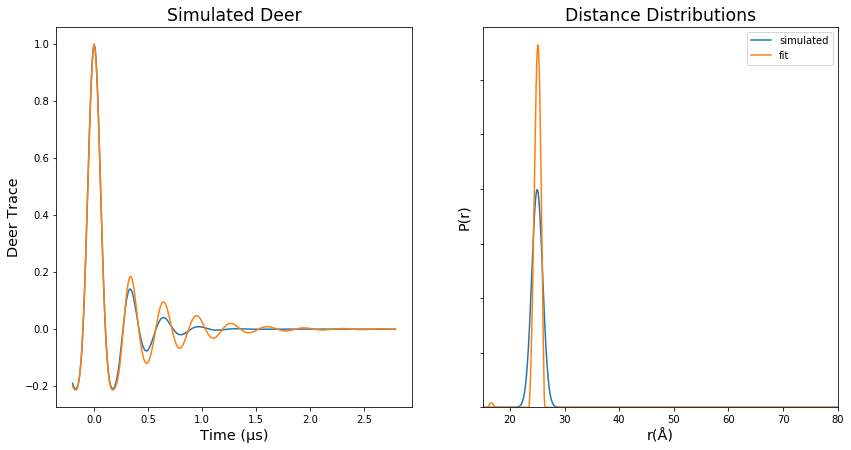

In [7]:
params = [[1,25,1]]
    
g_dist = g_dist_calc(params)
deer_sim, deer_out, dist_out = predict_deer(basis,g_dist,model)
fig = plot_fig(deer_sim,g_dist,deer_out,dist_out)